# Introduction

This work is based on the implementation of the paper [*Personalized Federated Learning with Moreau Envelopes*](https://arxiv.org/pdf/2006.08848). The implementation can be found [here](https://github.com/CharlieDinh/pFedMe). Note that this repository not only implements pFedMe but also FedAvg and Per-FedAvg algorithms that will allow further analysis. 

In this project, we focus exclusively on the MNIST dataset. We investigate the impact of using different levels of non-iidness and the effects of data poisoning attacks.

In [1]:
from utils.plot_result_utils import *

# Baseline

In order to establish a baseline for comparison and to replicate the results of the paper, we executed the following commands:

- **Strongly Convex Case:** referred as MLR
    - pFedMe:
        ```
        python3 main.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.1 --beta 2 --lamda 15 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 main.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 main.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.03 --beta 0.003  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

- **Non-Convex Case:** referred as DNN
    - pFedMe:
        ```
        python3 main.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.05 --beta 2 --lamda 30 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 main.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 main.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --beta 0.001  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

All results are stored in the 'results_baseline' folder.

Each algorithm is executed at least 10 times, and the results are then averaged using the `average_data()` function in the [plot_utils.py](./utils/plot_utils.py) file. The averaged results are stored in the XXX_avg.h5 files, note that the averaging is done along the columns. Additionally, the results of each training round are stored in the XXX.h5 files using the `save_results()` function in the [serverbase.py](./FLAlgorithms/servers/serverbase.py) file.

In [2]:
num_users = 5
folders = ["./results_baseline/results_DNN", "./results_baseline/results_MLR"]

## Average

In [3]:
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.967495,255,0.964328,0.005871
1,pFedMe,results_DNN,0.962392,768,0.945911,0.052792
2,PerAvg_p,results_DNN,0.941550,794,0.903445,0.065206
3,FedAvg,results_DNN,0.960448,570,0.944583,0.056024
4,pFedMe_p,results_MLR,0.939390,76,0.932108,0.002517
5,pFedMe,results_MLR,0.919438,250,0.910344,0.038375
6,PerAvg_p,results_MLR,0.933477,470,0.925235,0.013431
7,FedAvg,results_MLR,0.925000,743,0.915224,0.043297


## Training rounds

In [4]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
33,FedAvg,results_DNN,0.962743,556,0.961744,0.000468
72,FedAvg,results_MLR,0.929266,780,0.928483,0.000621
23,PerAvg_p,results_DNN,0.942765,795,0.941712,0.000768
66,PerAvg_p,results_MLR,0.935745,470,0.934746,0.000694
10,pFedMe,results_DNN,0.965173,782,0.963688,0.000630
50,pFedMe,results_MLR,0.924406,433,0.923785,0.000580
0,pFedMe_p,results_DNN,0.970572,184,0.969546,0.000712
42,pFedMe_p,results_MLR,0.944114,39,0.942414,0.001208


./results_baseline/results_DNN
[array([0.93559665, 0.93557235, 0.93844492, 0.94108261, 0.94267954,
       0.94485421, 0.94611231, 0.94702619, 0.94771193, 0.94836528,
       0.94918871, 0.94966928, 0.95009044, 0.95083963, 0.95127835,
       0.95168602, 0.95203699, 0.9524892 , 0.95280103, 0.95310205,
       0.95341523, 0.95364066, 0.95387284, 0.95416982, 0.95449379,
       0.95483936, 0.95514714, 0.95541577, 0.95570599, 0.95598407,
       0.95617036, 0.95632559, 0.95661582, 0.95680481, 0.95704914,
       0.95718008, 0.95733801, 0.95741091, 0.95768359, 0.95788742,
       0.95808045, 0.95828699, 0.95849082, 0.95862581, 0.95877295,
       0.95893494, 0.95907397, 0.95926836, 0.9594155 , 0.95953969,
       0.95970032, 0.95977727, 0.9599433 , 0.9600324 , 0.96021058,
       0.96039282, 0.9605818 , 0.96085853, 0.96098812, 0.96118116,
       0.96131884, 0.96144573, 0.96158477, 0.96170626, 0.96181695,
       0.96198839, 0.96211933, 0.96218278, 0.96226377, 0.96235826,
       0.9624649 , 0.96261744,

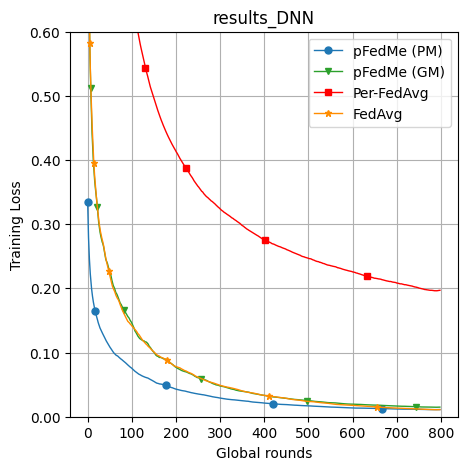

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


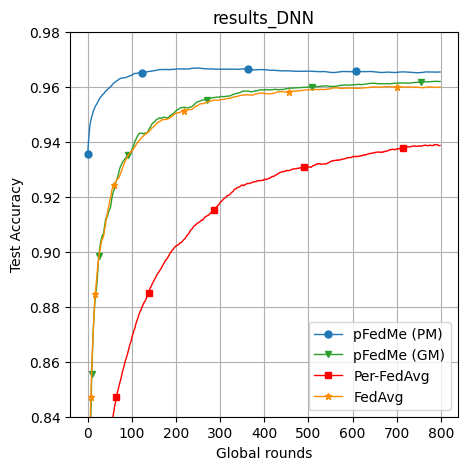

./results_baseline/results_MLR
[array([0.92443035, 0.92434395, 0.92532802, 0.92605022, 0.92656183,
       0.92689255, 0.92751215, 0.92820059, 0.9286933 , 0.92944654,
       0.93000405, 0.93034557, 0.93072624, 0.93093683, 0.93116631,
       0.93168467, 0.93192765, 0.93210853, 0.93231641, 0.93233396,
       0.9325378 , 0.93260664, 0.93263364, 0.93277673, 0.93293197,
       0.93314795, 0.93342063, 0.93366496, 0.93388904, 0.93406048,
       0.93411987, 0.93414552, 0.9343426 , 0.93455589, 0.93466388,
       0.93473947, 0.93480967, 0.93505265, 0.93522138, 0.93542522,
       0.93556965, 0.93578834, 0.93590848, 0.93601242, 0.93616901,
       0.93640794, 0.93650918, 0.93666712, 0.93662392, 0.93651188,
       0.93659287, 0.93671166, 0.9368183 , 0.9368156 , 0.9369263 ,
       0.93694654, 0.93708153, 0.93723812, 0.93727457, 0.93722732,
       0.93718817, 0.93709503, 0.93707073, 0.93704374, 0.93699649,
       0.93698839, 0.93702349, 0.93695194, 0.93699109, 0.93711258,
       0.93705589, 0.93697624,

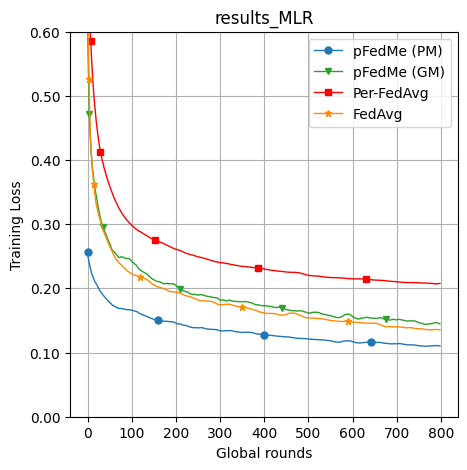

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


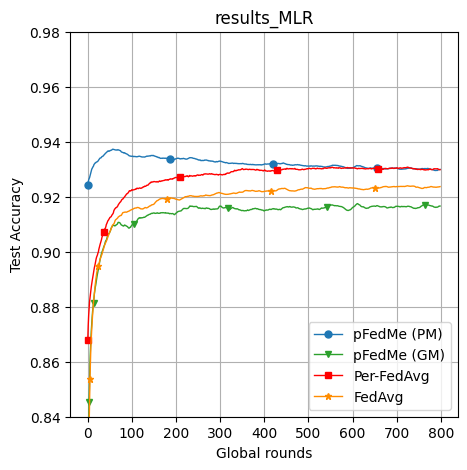

In [5]:
plot_comparison(num_users=num_users, folders=folders)

# Non-iidness

## Baseline

<img src="./results_images/datasets/baseline_train.png" alt="Distribution for the baseline" width="60%">

## Dirichlet

### $\alpha=1$

<img src="./results_images/datasets/dirichlet/mnist_train_D1.png" alt="Distribution for $\alpha=1$" width="60%">

In [6]:
folders = ["./results_dirichlet/alpha_1/results_DNN","./results_dirichlet/alpha_1/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.977372,784,0.964843,0.025950
1,pFedMe,results_DNN,0.974254,780,0.957834,0.047064
2,PerAvg_p,results_DNN,0.921102,794,0.883482,0.073450
3,FedAvg,results_DNN,0.971269,779,0.953888,0.043828
4,pFedMe_p,results_MLR,0.921695,796,0.913050,0.026775
5,pFedMe,results_MLR,0.914566,711,0.904454,0.037627
6,PerAvg_p,results_MLR,0.921055,774,0.905383,0.036125
7,FedAvg,results_MLR,0.919823,738,0.912985,0.032942


In [7]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
33,FedAvg,results_DNN,0.972348,796,0.972102,0.000198
70,FedAvg,results_MLR,0.922841,703,0.921982,0.000427
25,PerAvg_p,results_DNN,0.922241,794,0.921302,0.000436
61,PerAvg_p,results_MLR,0.922108,794,0.921482,0.000335
14,pFedMe,results_DNN,0.975613,778,0.975033,0.000322
53,pFedMe,results_MLR,0.918443,635,0.917497,0.000512
4,pFedMe_p,results_DNN,0.978745,784,0.977799,0.000396
44,pFedMe_p,results_MLR,0.923774,754,0.923108,0.000448


./results_dirichlet/alpha_1/results_DNN
[array([0.84646855, 0.86301906, 0.87303505, 0.880004  , 0.88548241,
       0.88991205, 0.89366138, 0.89706257, 0.89979311, 0.9023704 ,
       0.90465152, 0.90655117, 0.90843084, 0.91003731, 0.91154651,
       0.91291245, 0.91434602, 0.9155637 , 0.91667611, 0.91780817,
       0.91882563, 0.91985275, 0.92080057, 0.9217494 , 0.92266158,
       0.92339952, 0.92425806, 0.92504364, 0.92583689, 0.92650686,
       0.92718483, 0.92797308, 0.92865305, 0.92945729, 0.93013493,
       0.93083289, 0.93140192, 0.93201892, 0.93261194, 0.93320829,
       0.93381863, 0.93440832, 0.93486141, 0.93536447, 0.93579558,
       0.9363806 , 0.93681803, 0.93737373, 0.93785481, 0.93831423,
       0.93870003, 0.93917444, 0.93962753, 0.94007263, 0.94040212,
       0.94084888, 0.94124467, 0.94166045, 0.94200993, 0.94240338,
       0.94268324, 0.94301473, 0.94346582, 0.94385694, 0.94424507,
       0.94452259, 0.94481143, 0.94509695, 0.94541345, 0.94581157,
       0.94614905, 0.

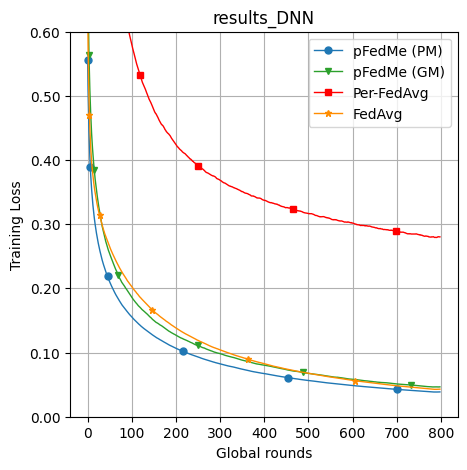

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


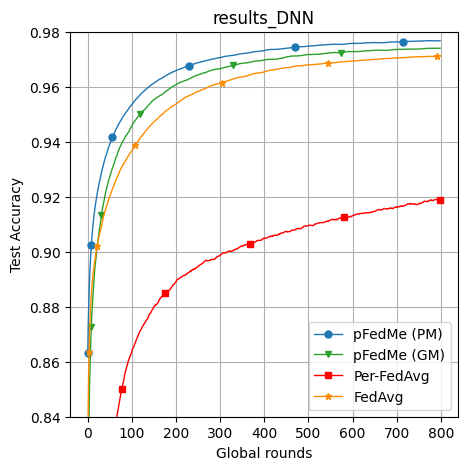

./results_dirichlet/alpha_1/results_MLR
[array([0.80209188, 0.82849047, 0.84014426, 0.84914112, 0.85541644,
       0.86074094, 0.86501066, 0.86848414, 0.87138026, 0.87397055,
       0.87596882, 0.8777442 , 0.87952459, 0.88132929, 0.88258462,
       0.88376599, 0.88500833, 0.88597215, 0.88683902, 0.88781716,
       0.88859075, 0.88950593, 0.89020256, 0.89077525, 0.89136894,
       0.89202259, 0.89277985, 0.8931823 , 0.89366071, 0.89415778,
       0.89471848, 0.8952432 , 0.89575526, 0.89613106, 0.89659548,
       0.89701659, 0.89741405, 0.89769989, 0.89817064, 0.89856843,
       0.89890958, 0.89919043, 0.89962553, 0.89994303, 0.90028451,
       0.9005044 , 0.90078325, 0.90124467, 0.90156083, 0.90170709,
       0.90194796, 0.90211554, 0.90232143, 0.90266025, 0.90287147,
       0.90301872, 0.90324294, 0.90355844, 0.90373501, 0.90383362,
       0.90397721, 0.90410381, 0.90426439, 0.90446695, 0.90458755,
       0.90487573, 0.90496369, 0.90508229, 0.90515292, 0.90532183,
       0.90536814, 0.

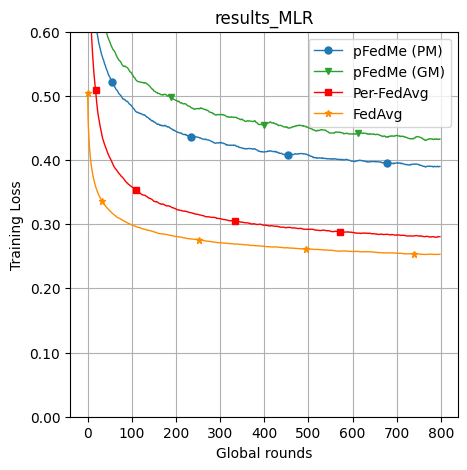

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


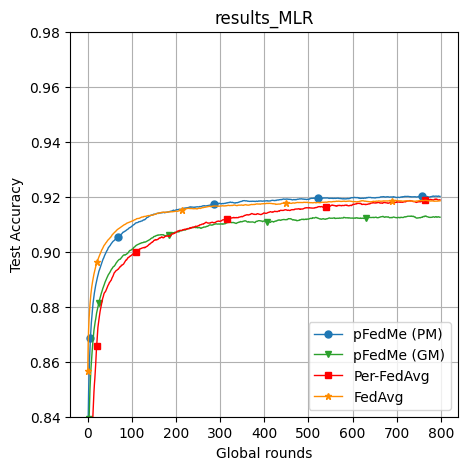

In [8]:
plot_comparison(num_users=num_users, folders=folders)

### $\alpha=0.5$

<img src="./results_images/datasets/dirichlet/mnist_train_D0_5.png" alt="Distribution for $\alpha=0.5$" width="60%">

In [9]:
folders = ["./results_dirichlet/alpha_0_5/results_DNN","./results_dirichlet/alpha_0_5/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.979724,784,0.967467,0.022844
1,pFedMe,results_DNN,0.976559,796,0.957592,0.049178
2,PerAvg_p,results_DNN,0.925360,775,0.892383,0.068354
3,FedAvg,results_DNN,0.972588,792,0.952724,0.046895
4,pFedMe_p,results_MLR,0.923534,767,0.915176,0.023381
5,pFedMe,results_MLR,0.913186,781,0.902079,0.038613
6,PerAvg_p,results_MLR,0.924594,610,0.911845,0.031827
7,FedAvg,results_MLR,0.920103,655,0.911180,0.034674


In [10]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
35,FedAvg,results_DNN,0.974147,794,0.973454,0.000337
70,FedAvg,results_MLR,0.923441,666,0.923061,0.000211
20,PerAvg_p,results_DNN,0.926373,775,0.925606,0.000456
64,PerAvg_p,results_MLR,0.925573,610,0.925193,0.000260
10,pFedMe,results_DNN,0.977878,792,0.977279,0.000390
59,pFedMe,results_MLR,0.917377,730,0.915985,0.000601
1,pFedMe_p,results_DNN,0.980610,774,0.980084,0.000313
49,pFedMe_p,results_MLR,0.925973,730,0.925027,0.000513


./results_dirichlet/alpha_0_5/results_DNN
[array([0.86409382, 0.87781517, 0.88616371, 0.89245169, 0.89708289,
       0.90063799, 0.90386261, 0.90665312, 0.9091851 , 0.91160514,
       0.91348547, 0.91553205, 0.91703758, 0.91835188, 0.9195579 ,
       0.92070995, 0.9218217 , 0.92302505, 0.92397188, 0.92499434,
       0.92585188, 0.92664812, 0.92755564, 0.92840052, 0.9290625 ,
       0.9297558 , 0.93046375, 0.93119403, 0.93189466, 0.93252632,
       0.93316065, 0.933749  , 0.93439366, 0.93500966, 0.93559568,
       0.9361787 , 0.93667777, 0.93714752, 0.93768657, 0.93810868,
       0.93865272, 0.93913913, 0.93951559, 0.93984308, 0.94034781,
       0.9407426 , 0.94117004, 0.9415705 , 0.94198694, 0.94240438,
       0.94276219, 0.94312966, 0.94349747, 0.94382696, 0.94417444,
       0.94451792, 0.94489839, 0.94521189, 0.94559035, 0.94591918,
       0.94624933, 0.94647954, 0.94683136, 0.94723114, 0.94748134,
       0.94772588, 0.94802539, 0.94839852, 0.94865672, 0.94895856,
       0.9492474 , 

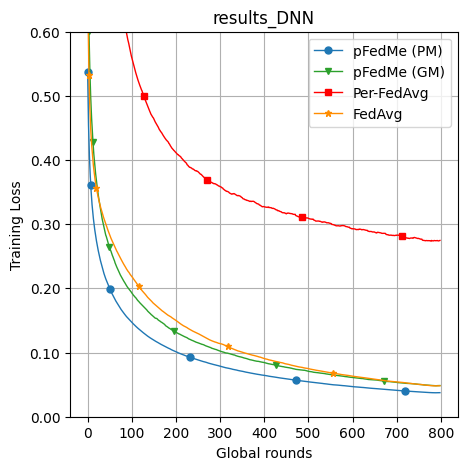

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


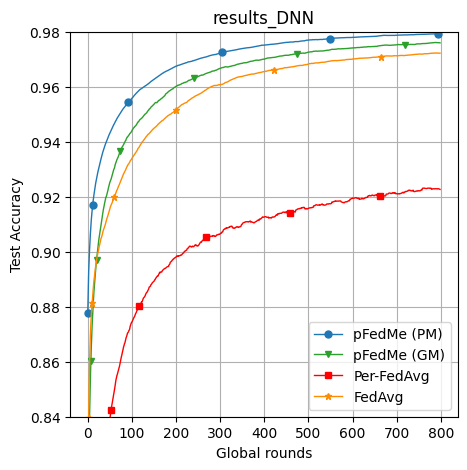

./results_dirichlet/alpha_0_5/results_MLR
[array([0.8139299 , 0.83525986, 0.84736974, 0.85537813, 0.86141624,
       0.8663716 , 0.8708732 , 0.87421342, 0.87729178, 0.87946462,
       0.88169476, 0.88390758, 0.88583889, 0.88746202, 0.88897721,
       0.89006097, 0.89114705, 0.89218284, 0.89303538, 0.89377965,
       0.89477545, 0.89560268, 0.89660215, 0.89722381, 0.89778585,
       0.89809502, 0.89874067, 0.8990575 , 0.89955657, 0.90017824,
       0.90064832, 0.90098314, 0.90147954, 0.90183469, 0.90204991,
       0.90251466, 0.90257629, 0.90286447, 0.90317797, 0.90347515,
       0.90377732, 0.90397388, 0.90405017, 0.90431836, 0.90467417,
       0.90507263, 0.9053105 , 0.90571095, 0.90591185, 0.90598381,
       0.90615505, 0.90645456, 0.90652719, 0.90670043, 0.90704524,
       0.90723114, 0.90764226, 0.90765925, 0.90792644, 0.908121  ,
       0.90819163, 0.90827425, 0.90848148, 0.90865438, 0.90878798,
       0.90894889, 0.90897755, 0.90902485, 0.90928438, 0.90938799,
       0.9096202 , 

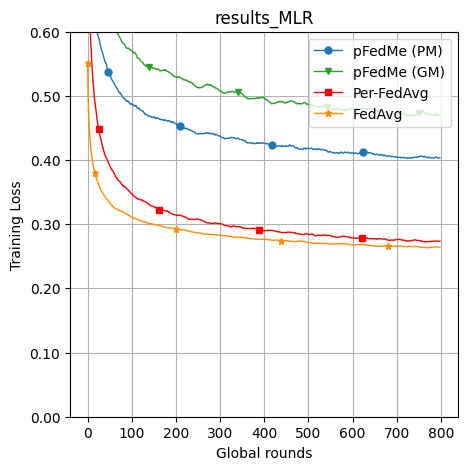

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


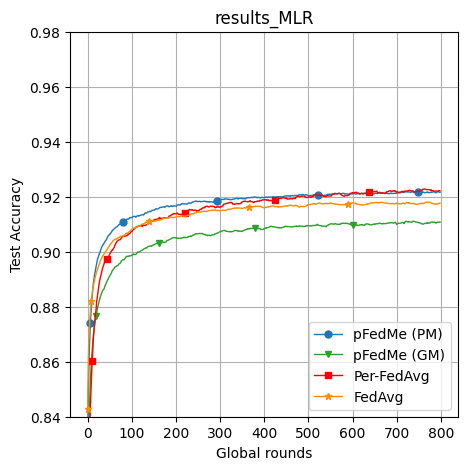

In [11]:
plot_comparison(num_users=num_users, folders=folders)

### $\alpha=0.2$

<img src="./results_images/datasets/dirichlet/mnist_train_D0_2.png" alt="Distribution for $\alpha=0.2$" width="60%">

In [12]:
folders = ["./results_dirichlet/alpha_0_2/results_DNN","./results_dirichlet/alpha_0_2/results_MLR"]
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.979379,780,0.967128,0.020793
1,pFedMe,results_DNN,0.973163,798,0.950380,0.055186
2,PerAvg_p,results_DNN,0.925645,781,0.895766,0.057138
3,FedAvg,results_DNN,0.914285,791,0.901413,0.038465
4,pFedMe_p,results_MLR,0.926457,571,0.918378,0.020592
5,pFedMe,results_MLR,0.907555,731,0.894365,0.040768
6,PerAvg_p,results_MLR,0.924519,799,0.910808,0.030203
7,FedAvg,results_MLR,0.913352,690,0.901412,0.038657


In [13]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
32,FedAvg,results_DNN,0.918316,509,0.917556,0.000500
77,FedAvg,results_MLR,0.918316,773,0.917736,0.000492
27,PerAvg_p,results_DNN,0.926711,781,0.925698,0.000614
63,PerAvg_p,results_MLR,0.925378,799,0.924612,0.000289
17,pFedMe,results_DNN,0.975481,798,0.974162,0.000574
56,pFedMe,results_MLR,0.911786,629,0.910734,0.000599
7,pFedMe_p,results_DNN,0.981211,786,0.979799,0.000591
44,pFedMe_p,results_MLR,0.928576,688,0.928210,0.000406


./results_dirichlet/alpha_0_2/results_DNN
[array([0.87173762, 0.88330335, 0.89007329, 0.89586781, 0.9002302 ,
       0.90419448, 0.90717036, 0.90993304, 0.91241822, 0.91496402,
       0.91698981, 0.91869978, 0.92007862, 0.92134786, 0.92263342,
       0.92378873, 0.9249497 , 0.92610534, 0.92721634, 0.92822173,
       0.9290539 , 0.92992371, 0.93066793, 0.93135585, 0.9319375 ,
       0.93260344, 0.93319741, 0.93379472, 0.93436438, 0.93488074,
       0.93554334, 0.93611633, 0.93659771, 0.93720701, 0.93770504,
       0.93819475, 0.93859418, 0.93907356, 0.93942801, 0.9397808 ,
       0.94016257, 0.94048771, 0.94092478, 0.94137784, 0.94191852,
       0.9423406 , 0.94265208, 0.94302552, 0.94343061, 0.94382537,
       0.94418149, 0.94452995, 0.94490872, 0.94520121, 0.9455057 ,
       0.9458295 , 0.9461593 , 0.94641848, 0.94672097, 0.94701612,
       0.94740389, 0.94772303, 0.9480002 , 0.94824938, 0.94850956,
       0.94873609, 0.94911786, 0.94934306, 0.94961523, 0.94984543,
       0.95008428, 

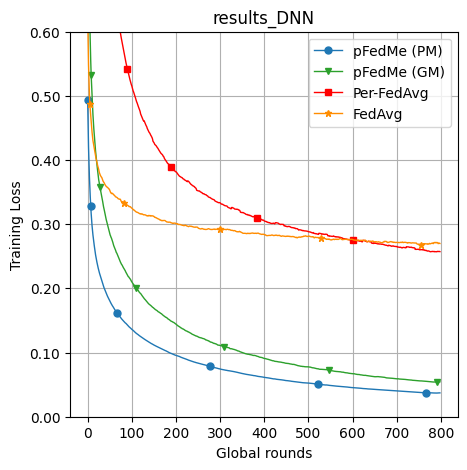

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


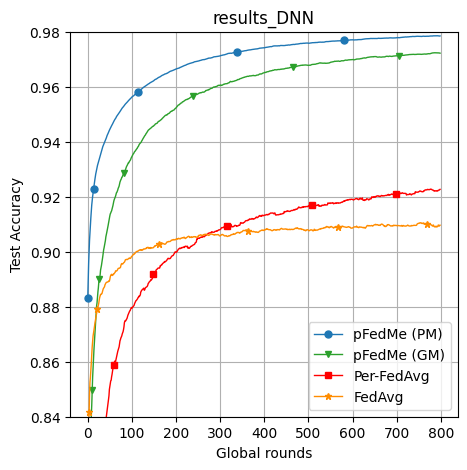

./results_dirichlet/alpha_0_2/results_MLR
[array([0.82309214, 0.83899061, 0.84937671, 0.85824106, 0.86413319,
       0.86986675, 0.87482744, 0.87869712, 0.88169265, 0.88404857,
       0.88626891, 0.88799287, 0.88925511, 0.89066127, 0.8920068 ,
       0.89289027, 0.89392031, 0.89475015, 0.89591978, 0.89682191,
       0.89764974, 0.89834066, 0.89880239, 0.89936105, 0.89996902,
       0.90064994, 0.9011693 , 0.90169632, 0.90204044, 0.90245586,
       0.90295456, 0.90333567, 0.90383636, 0.90428143, 0.90469252,
       0.90513559, 0.90557699, 0.90608801, 0.90636185, 0.90665534,
       0.90674262, 0.90686788, 0.90718635, 0.90753581, 0.90773569,
       0.90785928, 0.90802552, 0.90813112, 0.90835332, 0.9086055 ,
       0.90879439, 0.90907855, 0.90936105, 0.90956026, 0.90986008,
       0.91007262, 0.91019322, 0.91032147, 0.91053701, 0.91076554,
       0.91095909, 0.91114731, 0.9112839 , 0.91146312, 0.9117203 ,
       0.9119525 , 0.91221634, 0.9123969 , 0.91262076, 0.91271837,
       0.91290193, 

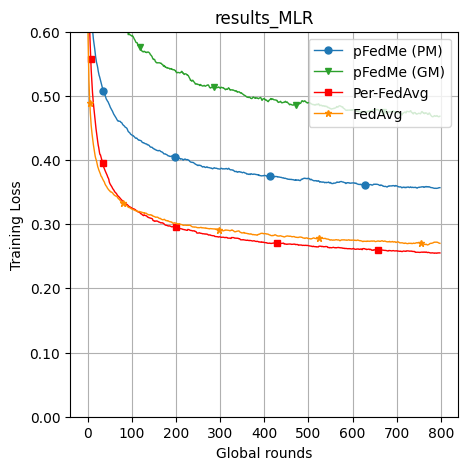

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


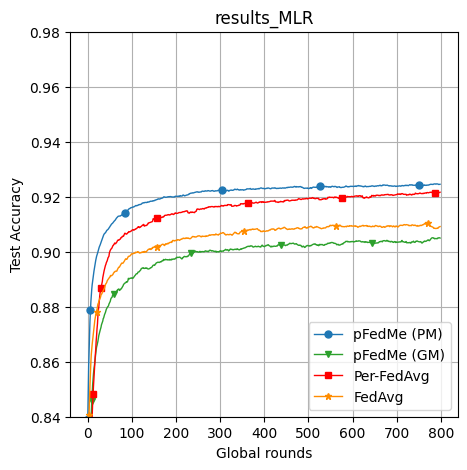

In [14]:
plot_comparison(num_users=num_users, folders=folders)

# Attacks

- **Strongly Convex Case:** referred as MLR
    - pFedMe:
        ```
        python3 attacks.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.1 --beta 2 --lamda 15 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 attacks.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 attacks.py --dataset Mnist --model mclr --batch_size 20 --learning_rate 0.03 --beta 0.003  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

- **Non-Convex Case:** referred as DNN
    - pFedMe:
        ```
        python3 attacks.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.01 --personal_learning_rate 0.05 --beta 2 --lamda 30 --num_global_iters 800 --local_epochs 20 --algorithm pFedMe --numusers 5 --times 10
        ```
    - FedAvg:
        ```
        python3 attacks.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --num_global_iters 800 --local_epochs 20 --algorithm FedAvg --numusers 5 --times 10
        ```
    - PerAvg:
        ```
        python3 attacks.py --dataset Mnist --model dnn --batch_size 20 --learning_rate 0.02 --beta 0.001  --num_global_iters 800 --local_epochs 20 --algorithm PerAvg --numusers 5 --times 10
        ```

In [15]:
num_users = 5
#folders = ["./results_attacks/results_DNN", "./results_attacks/results_MLR"]
#folders = ["./results_attacks/results_MLR"]
folders = ["./results_attacks/results_DNN"]

## Average

In [16]:
max_average_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean,Std
0,pFedMe_p,results_DNN,0.938796,0,0.110663,0.051676
1,pFedMe,results_DNN,0.278915,4,0.105869,0.013667
2,PerAvg_p,results_DNN,0.771517,69,0.676258,0.058320
3,FedAvg,results_DNN,0.400027,3,0.109110,0.030311


## Training rounds

In [17]:
max_df(num_users=num_users, folders=folders)

,Algorithm,Folder,Max testing Accuracy,Index,Mean Max testing Accuracy,Std Max testing Accuracy
36,FedAvg,results_DNN,0.740551,5,0.531965,0.136621
25,PerAvg_p,results_DNN,0.938715,687,0.833180,0.122022
11,pFedMe,results_DNN,0.676296,5,0.431263,0.127955
1,pFedMe_p,results_DNN,0.952754,0,0.938796,0.021737


./results_attacks/results_DNN
[array([0.36225567, 0.32052646, 0.29225297, 0.26795626, 0.2481493 ,
       0.22798731, 0.21147138, 0.19478942, 0.1799703 , 0.16336258,
       0.15200054, 0.14095707, 0.13545896, 0.12978537, 0.12408207,
       0.11828429, 0.11278213, 0.10715848, 0.10473677, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 0.10421166, 0.10421166, 0.10421166,
       0.10421166, 0.10421166, 

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 500x500 with 1 Axes>

Algorithm 0: pFedMe_p, Data length: 799
Algorithm 1: pFedMe, Data length: 799
Algorithm 2: PerAvg_p, Data length: 799
Algorithm 3: FedAvg, Data length: 799


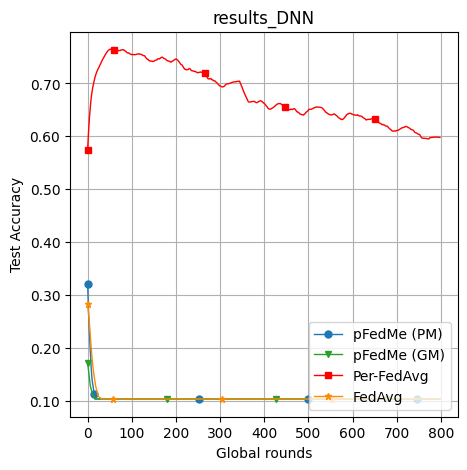

In [18]:
plot_comparison(num_users=num_users, folders=folders, y_lim=False)

In [19]:

hf = h5py.File('results_attacks/results_DNN/Mnist_PerAvg_p_0.02_0.001_15_5u_20b_20_avg.h5', 'r')
rs_glob_acc = np.array(hf.get('rs_glob_acc')[:])
rs_train_acc = np.array(hf.get('rs_train_acc')[:])
rs_train_loss = np.array(hf.get('rs_train_loss')[:])
print(rs_train_acc, rs_train_loss[~np.isnan(rs_train_loss)], rs_glob_acc)


[0.30001806 0.30353918 0.38224088 0.40105634 0.44934092 0.48535572
 0.48903034 0.5217407  0.54602745 0.56704586 0.59154027 0.60962441
 0.61939328 0.62396172 0.64231672 0.6468039  0.65431564 0.65940773
 0.67157819 0.6743048  0.67966775 0.68462441 0.68804623 0.69866378
 0.69683099 0.69551282 0.70492055 0.70444204 0.70433369 0.70755688
 0.71357891 0.71693752 0.71649512 0.72035031 0.71779523 0.72778079
 0.72700433 0.73057963 0.72521668 0.72970386 0.72692308 0.73218671
 0.73548212 0.73566269 0.72769953 0.73514807 0.74144998 0.74346334
 0.74381546 0.75058685 0.75092091 0.74990069 0.75272662 0.75397255
 0.75378295 0.75617551 0.76069881 0.75604009 0.76193572 0.75903756
 0.7627844  0.75967858 0.7599043  0.75807151 0.76255869 0.75842362
 0.76021127 0.75744854 0.7592091  0.76540267 0.75808956 0.75427049
 0.75860419 0.75033406 0.75355724 0.75061394 0.75195919 0.75917299
 0.75447815 0.75399061 0.75781871 0.76035572 0.76266703 0.75725894
 0.76209823 0.76462622 0.75902853 0.76561033 0.76437342 0.7624